In [99]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import RandomizedSearchCV

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import learning_curve

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

pd.set_option('display.max_columns', None)

In [74]:
df = pd.read_csv('data/dataset_workout.csv')
df.head(3)

,Gender,Weight (kg),Height (m),Workout_Type,Workout_Frequency (days),BMI,Daily meals frequency,diet_type,rating,Name of Exercise,Sets,Reps,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,cluster_id,E,I,workload,S,D,R
0,Male,65.27,1.62,Strength,4,24.87,3,Vegan,1.31,Decline Push-ups,5,21,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,2,0.570217,0.526466,105,0.250000,0.333333,0.637310
1,Female,56.41,1.55,HIIT,4,23.48,3,Vegetarian,1.92,Bear Crawls,4,16,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,2,0.740993,0.256055,64,0.225000,0.575163,0.862514
2,Female,58.98,1.67,Cardio,3,21.15,2,Paleo,4.70,Dips,5,22,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,1,0.549660,0.289199,110,0.416667,0.274510,0.685580


In [75]:
user = pd.read_csv('data/new_user.csv')
user 

,Age,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,Goal,WeightChange (kg),GoalDays,cluster_id,BMR,PAL,TDEE,CalorieChange,CaloriesToBurnTraining,CaloriesReducedFromFood,CaloriesPerDay,TotalWorkouts,CaloriesPerWorkout
0,22,Male,88.0,1.8,27.160494,2,3,3,Keto,Maintain,3.0,30,0,1900.0,1.725,3277.5,23100.0,11550.0,11550.0,3277.5,12.857143,898.333333


### Target calculation depending on goal from user

In [76]:
goal = user['Goal'].iloc[0]

if goal == 'Loss':
    df['target'] = 0.45*df['E'] + 0.25*df['I'] + 0.10*df['D'] + 0.05*df['S'] + 0.15*df['R']
elif goal == 'Maintain':
    df['target'] = 0.25*df['E'] + 0.20*df['I'] + 0.15*df['D'] + 0.20*df['S'] + 0.20*df['R']
elif goal == 'Gain':
    df['target'] = 0.05*df['E'] + 0.15*df['I'] + 0.10*df['D'] + 0.50*df['S'] + 0.20*df['R']
else:
    raise ValueError("Goal must be one of: 'Loss', 'Maintain', 'Gain'")

### Training dataset preparation

In [77]:
df.columns

Index(['Gender', 'Weight (kg)', 'Height (m)', 'Workout_Type',
       'Workout_Frequency (days)', 'BMI', 'Daily meals frequency', 'diet_type',
       'rating', 'Name of Exercise', 'Sets', 'Reps', 'Benefit',
       'Target Muscle Group', 'Equipment Needed', 'Body Part',
       'Type of Muscle', 'Workout', 'cluster_id', 'E', 'I', 'workload', 'S',
       'D', 'R', 'target'],
      dtype='object')

In [78]:
numerical_features = ['Weight (kg)', 'Height (m)', 'BMI', 
                      'Workout_Frequency (days)', 'Daily meals frequency', 'Sets', 'Reps', 'rating', 'workload']

categorical_features = ['Gender', 'Workout_Type', 'diet_type', 'Name of Exercise', 'Benefit',
                        'Target Muscle Group', 'Equipment Needed', 'Body Part',
                        'Type of Muscle', 'Workout', 'cluster_id'
                        ]

In [79]:
# 3) Split X/y
X = df.drop(columns=['target'])
y = df['target']

X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.30, random_state=42
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42
)

In [80]:
# 4) One-hot encoding (fit on train only, transform val/test)
preprocess = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features),
    ],
    remainder="drop"
)

X_train_enc = preprocess.fit_transform(X_train)
X_val_enc   = preprocess.transform(X_val)
X_test_enc  = preprocess.transform(X_test)

### Baseline model: Linear Regression

In [81]:
lr = LinearRegression()
lr.fit(X_train_enc, y_train)
val_pred_lr = lr.predict(X_val_enc)

rmse_lr = np.sqrt(mean_squared_error(y_val, val_pred_lr))

print(f"Validation RMSE (Linear Regression): {rmse_lr:.4f}")

Validation RMSE (Linear Regression): 0.0797


### Main model: XGBoost

In [82]:
# --------------------------------------------------
# Manual selection of n_estimators using VALIDATION
# --------------------------------------------------

n_estimators_list = [50, 100, 200, 300, 500]
results = []

for n in n_estimators_list:
    model = XGBRegressor(
        n_estimators=n,
        learning_rate=0.05,
        max_depth=5,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42
    )
    
    model.fit(X_train_enc, y_train)
    val_pred = model.predict(X_val_enc)
    
    rmse = np.sqrt(mean_squared_error(y_val, val_pred))
    results.append((n, rmse))

# --------------------------------------------------
# Select best n_estimators
# --------------------------------------------------

best_n, best_rmse = min(results, key=lambda x: x[1])
print(f"Best n_estimators: {best_n}")
print(f"Validation RMSE: {best_rmse:.4f}")

# --------------------------------------------------
# Train FINAL model on training data
# --------------------------------------------------

final_model = XGBRegressor(
    n_estimators=best_n,
    learning_rate=0.05,
    max_depth=5,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="reg:squarederror",
    random_state=42
)

final_model.fit(X_train_enc, y_train);  


Best n_estimators: 500
Validation RMSE: 0.0621


In [83]:
test_pred = final_model.predict(X_test_enc)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test RMSE: {test_rmse:.4f}")

Test RMSE: 0.0635


### Hyperparameter tuning

In [84]:
# Base model (we keep objective fixed for regression)
xgb = XGBRegressor(
    objective="reg:squarederror",
    random_state=42,
    n_jobs=-1
)

# Parameter search space (covers the big knobs)
param_distributions = {
    "n_estimators": [100, 200, 300, 500, 800, 1200],
    "learning_rate": [0.01, 0.03, 0.05, 0.08, 0.1, 0.2],
    "max_depth": [2, 3, 4, 5, 6, 8],
    "min_child_weight": [1, 2, 5, 10],
    "subsample": [0.6, 0.8, 0.9, 1.0],
    "colsample_bytree": [0.6, 0.8, 0.9, 1.0],
    "gamma": [0, 0.1, 0.3, 0.5, 1.0],
    "reg_alpha": [0, 1e-4, 1e-3, 1e-2, 0.1, 1.0],
    "reg_lambda": [0.5, 1.0, 2.0, 5.0, 10.0],
}

# Use neg MSE for max compatibility with older sklearn,
# then we take sqrt later for RMSE.
search = RandomizedSearchCV(
    estimator=xgb,
    param_distributions=param_distributions,
    n_iter=40,                 # increase to 80+ if you can afford time
    scoring="neg_mean_squared_error",
    cv=5,
    verbose=1,
    random_state=42,
    n_jobs=-1
)

search.fit(X_train_enc, y_train)

print("Best CV params:", search.best_params_)
print("Best CV RMSE:", np.sqrt(-search.best_score_))


Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best CV params: {'subsample': 0.9, 'reg_lambda': 0.5, 'reg_alpha': 0.01, 'n_estimators': 500, 'min_child_weight': 1, 'max_depth': 8, 'learning_rate': 0.08, 'gamma': 0, 'colsample_bytree': 0.9}
Best CV RMSE: 0.06037780911779522


In [85]:
best_model = search.best_estimator_

val_pred = best_model.predict(X_val_enc)
val_rmse = np.sqrt(mean_squared_error(y_val, val_pred))

print(f"Validation RMSE after tuning: {val_rmse:.6f}")

Validation RMSE after tuning: 0.057778


In [86]:
test_pred = best_model.predict(X_test_enc)
test_rmse = np.sqrt(mean_squared_error(y_test, test_pred))
print(f"Test RMSE: {test_rmse:.6f}")


Test RMSE: 0.058928


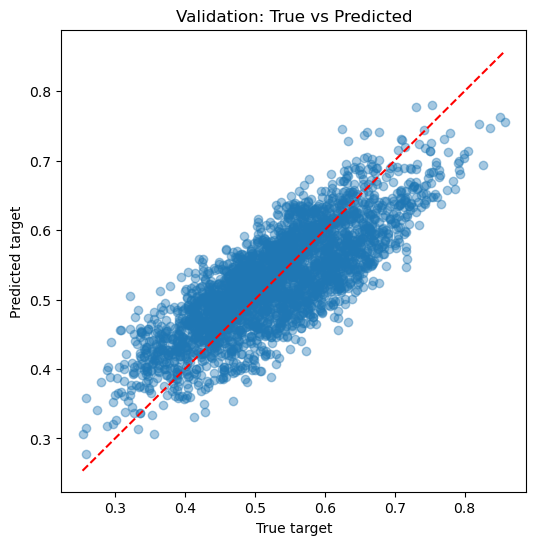

In [87]:
plt.figure(figsize=(6,6))
plt.scatter(y_val, val_pred, alpha=0.4)
plt.plot([y_val.min(), y_val.max()],
         [y_val.min(), y_val.max()],
         'r--')
plt.xlabel("True target")
plt.ylabel("Predicted target")
plt.title("Validation: True vs Predicted")
plt.show()


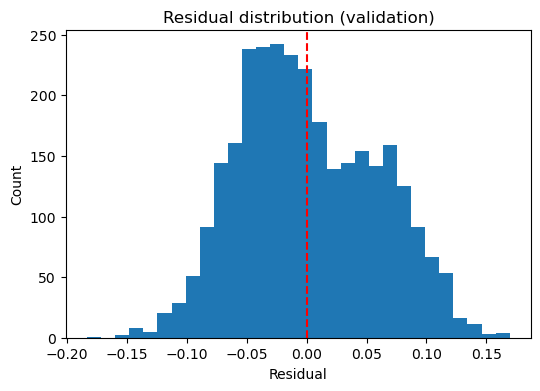

In [88]:
residuals = y_val - val_pred

plt.figure(figsize=(6,4))
plt.hist(residuals, bins=30)
plt.axvline(0, color="red", linestyle="--")
plt.title("Residual distribution (validation)")
plt.xlabel("Residual")
plt.ylabel("Count")
plt.show()


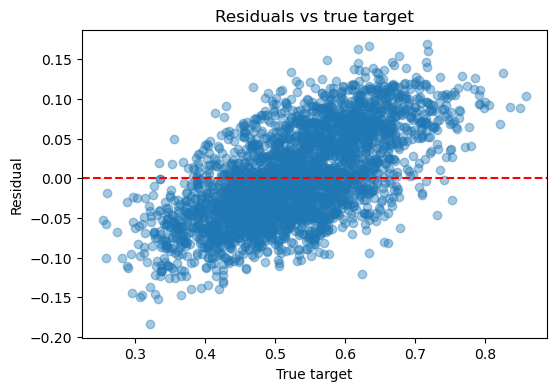

In [89]:
plt.figure(figsize=(6,4))
plt.scatter(y_val, residuals, alpha=0.4)
plt.axhline(0, color="red", linestyle="--")
plt.xlabel("True target")
plt.ylabel("Residual")
plt.title("Residuals vs true target")
plt.show()

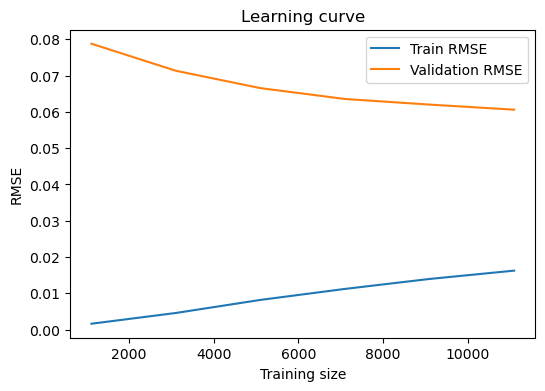

In [90]:
train_sizes, train_scores, val_scores = learning_curve(
    best_model,
    X_train_enc,
    y_train,
    cv=5,
    scoring="neg_mean_squared_error",
    train_sizes=np.linspace(0.1, 1.0, 6)
)

train_rmse = np.sqrt(-train_scores.mean(axis=1))
val_rmse   = np.sqrt(-val_scores.mean(axis=1))

plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_rmse, label="Train RMSE")
plt.plot(train_sizes, val_rmse, label="Validation RMSE")
plt.xlabel("Training size")
plt.ylabel("RMSE")
plt.title("Learning curve")
plt.legend()
plt.show()


<Axes: xlabel='bin'>

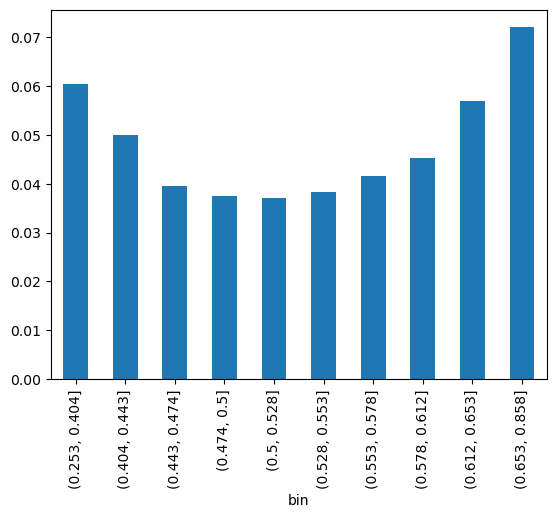

In [91]:
df_plot.groupby("bin", observed=True)["error"].mean().plot(kind="bar")

#### Save the model and encoder

In [92]:
import joblib

joblib.dump(preprocess, "encoder.pkl")
joblib.dump(final_model, "models/workout_model.pkl")

['models/workout_model.pkl']

### Create testing data

In [93]:
user = user.drop(
                    columns=['Age', 'Goal', 'WeightChange (kg)', 'GoalDays', 'BMR', 'PAL', 'TDEE', 'CalorieChange', 'CaloriesToBurnTraining', 
                        'CaloriesReducedFromFood', 'CaloriesPerDay',  'TotalWorkouts', 'CaloriesPerWorkout']
                )

In [94]:
user

,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id
0,Male,88.0,1.8,27.160494,2,3,3,Keto,0


In [95]:
# Exercise-related features
exercise_df = df[
                    ['Sets', 'Reps', 'rating', 'workload', 'Workout_Type', 'Name of Exercise', 'Benefit',
                        'Target Muscle Group', 'Equipment Needed', 'Body Part',
                        'Type of Muscle', 'Workout' ]
].reset_index(drop=True)

# Repeat user row to match number of exercises 
workout_predict = pd.concat(
    [pd.concat([user] * len(exercise_df), ignore_index=True), exercise_df],
    axis=1
)

workout_predict.head(3)

,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id,Sets,Reps,rating,workload,Workout_Type,Name of Exercise,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout
0,Male,88.0,1.8,27.160494,2,3,3,Keto,0,5,21,1.31,105,Strength,Decline Push-ups,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes
1,Male,88.0,1.8,27.160494,2,3,3,Keto,0,4,16,1.92,64,HIIT,Bear Crawls,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises
2,Male,88.0,1.8,27.160494,2,3,3,Keto,0,5,22,4.70,110,Cardio,Dips,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises


In [96]:
import joblib

preprocess = joblib.load("encoder.pkl")
final_model = joblib.load("models/workout_model.pkl")

workout_predict_enc = preprocess.transform(workout_predict)
predictions = final_model.predict(workout_predict_enc)

In [97]:
# Add predictions as a new column
workout_predict = workout_predict.copy()
workout_predict["workout_score"] = predictions


workout_predict.head(3)

,Gender,Weight (kg),Height (m),BMI,Experience_Level,Workout_Frequency (days),Daily meals frequency,diet_type,cluster_id,Sets,Reps,rating,workload,Workout_Type,Name of Exercise,Benefit,Target Muscle Group,Equipment Needed,Body Part,Type of Muscle,Workout,workout_score
0,Male,88.0,1.8,27.160494,2,3,3,Keto,0,5,21,1.31,105,Strength,Decline Push-ups,Improves shoulder health and posture,"Shoulders, Triceps",Cable Machine,Legs,Lats,Dumbbell flyes,0.533696
1,Male,88.0,1.8,27.160494,2,3,3,Keto,0,4,16,1.92,64,HIIT,Bear Crawls,Strengthens lower abs,"Back, Core, Shoulders",Step or Box,Chest,Lats,Lateral raises,0.485057
2,Male,88.0,1.8,27.160494,2,3,3,Keto,0,5,22,4.70,110,Cardio,Dips,Builds chest strength,"Quadriceps, Glutes",Step or Box,Arms,Grip Strength,Standing calf raises,0.565776


#### Top 100 most suitable exercises based on user profile and goal & Recommendation system

Why this is “classical recommender way”

This matches standard recommender architecture:

1) Candidate generation

Top-100 by predicted relevance (workout_score)

2) Content embedding

TF-IDF vectors from exercise metadata

3) Similarity-based grouping

Cosine similarity to “day prototypes” (a standard content-based trick)

4) Reranking for diversity

MMR is a classic diversification algorithm used in recommender systems.

In [ ]:
# ----------------------------
# 1) Candidate generation: Top N
# ----------------------------
TOP_N = 100
candidates = (
    workout_predict
    .sort_values("workout_score", ascending=False)
    .head(TOP_N)
    .reset_index(drop=True)
    .copy()
)
                       
                        
# ----------------------------
# 2) Build text for vectorization (classic content-based)
# ----------------------------
TEXT_COLS = ["Benefit", "Target Muscle Group", "Equipment Needed", "Workout", "Body Part", "Type of Muscle", "Workout_Type", "Name of Exercise"]

def make_text_profile(df: pd.DataFrame, cols=TEXT_COLS) -> pd.Series:
    tmp = df[cols].copy()
    for c in cols:
        tmp[c] = (tmp[c].astype(str).fillna("")
                  .str.lower()
                  .str.replace(r"\s+", " ", regex=True)
                  .str.strip())
    return tmp.apply(lambda r: " ".join([v for v in r.values if v and v != "nan"]), axis=1)

exercise_text = make_text_profile(candidates)

# TF-IDF vectors for exercises
vectorizer = TfidfVectorizer(ngram_range=(1, 2), min_df=1, max_features=5000)
X_ex = vectorizer.fit_transform(exercise_text)

# ----------------------------
# 3) Create "day prototypes" as text -> vector 
# ----------------------------
day_prototypes = {
    "Legs": "legs lower body quads quadriceps hamstrings glutes calves posterior",
    "Push": "chest shoulders triceps upper chest pressing push",
    "Pull": "back lats upper back biceps rows pull",
    "Core": "abs core obliques plank dead bug flutter kicks",
}

proto_text = list(day_prototypes.values())
X_proto = vectorizer.transform(proto_text)  # same vector space

# similarity of each exercise to each day prototype
S_day = cosine_similarity(X_ex, X_proto)   # shape: (n_exercises, 4)

day_names = list(day_prototypes.keys())
candidates["day_label"] = [day_names[i] for i in np.argmax(S_day, axis=1)]
candidates["day_sim"] = np.max(S_day, axis=1)  # confidence (how strongly it matches)

# ----------------------------
# 4) MMR reranking: relevant + diverse inside each day
# ----------------------------
def mmr_select(df_day: pd.DataFrame,
               X_day_vecs,
               k: int = 6,
               alpha: float = 0.7):
    """
    Classic MMR:
      score(item) = alpha * relevance(item) - (1-alpha) * max_sim(item, selected)
    where relevance = workout_score (you can also include day_sim if you want).
    """
    if len(df_day) == 0:
        return df_day

    # normalize relevance to 0..1 for stable mixing
    rel = df_day["workout_score"].to_numpy()
    rel = (rel - rel.min()) / (rel.max() - rel.min() + 1e-9)

    selected_idx = []
    remaining = list(range(len(df_day)))

    # Precompute cosine sims within the day candidate set
    sims = cosine_similarity(X_day_vecs, X_day_vecs)

    while remaining and len(selected_idx) < min(k, len(df_day)):
        if not selected_idx:
            # pick highest relevance first
            best = remaining[int(np.argmax(rel[remaining]))]
        else:
            mmr_scores = []
            for i in remaining:
                max_sim_to_selected = np.max(sims[i, selected_idx])
                mmr = alpha * rel[i] - (1 - alpha) * max_sim_to_selected
                mmr_scores.append(mmr)
            best = remaining[int(np.argmax(mmr_scores))]

        selected_idx.append(best)
        remaining.remove(best)

    return df_day.iloc[selected_idx].copy()

# ----------------------------
# 5) Build a daily plan: each day different, each internally balanced
# ----------------------------
EXERCISES_PER_DAY = 6
alpha = 0.75  # higher => more relevance; lower => more diversity

plan = {}
for day in day_names:
    df_day = candidates[candidates["day_label"] == day].copy()
    if len(df_day) == 0:
        plan[day] = df_day
        continue

    # get vectors corresponding to rows in df_day (same indices as candidates)
    idx = df_day.index.to_numpy()
    X_day = X_ex[idx]

    # MMR selection inside that day
    plan[day] = mmr_select(df_day, X_day, k=EXERCISES_PER_DAY, alpha=alpha)

# ----------------------------
# 6) Display / output
# ----------------------------
cols_show = ['Workout_Type', 'Workout', 'workload', 'Name of Exercise', 'Body Part', 'Target Muscle Group', 'Equipment Needed', 'Sets', 'Reps', 'Type of Muscle', 'Benefit', 'rating', 
                         ]

for day in day_names:
    print(f"\n===== {day} Day =====")
    display(plan[day][cols_show].reset_index(drop=True))



===== Legs Day =====


,Workout_Type,Workout,workload,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,rating
0,HIIT,Face pulls,115,Prone Cobras,Chest,"Glutes, Hamstrings","Bench, Barbell",5,23,Posterior,Strengthens core and improves mobility,4.47
1,HIIT,Bicep Curls,115,Mountain Climbers,Shoulders,Full Body,Pull-up Bar,5,23,Triceps,Builds lower body power,2.63
2,HIIT,Barbell squats,115,Glute Bridges,Forearms,"Glutes, Hamstrings",Dumbbells,5,23,Posterior,Builds calf muscles,4.51
3,HIIT,Decline dumbbell flyes,110,Lateral Raises,Shoulders,"Glutes, Hamstrings",Dumbbells,5,22,Lower Chest,Improves shoulder mobility and posture,2.33
4,HIIT,Overhead triceps extensions,115,Turkish Get-ups,Legs,"Back, Biceps",Bench or Step,5,23,Lower,Strengthens lower body,3.11
5,HIIT,Dumbbell flyes,125,Thrusters,Abs,"Glutes, Hamstrings, Core",Step or Box,5,25,Quads,Strengthens shoulders,4.79



===== Push Day =====


,Workout_Type,Workout,workload,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,rating
0,HIIT,Incline dumbbell flyes,115,Face Pulls,Arms,"Chest, Triceps",Dumbbells,5,23,Anterior,Strengthens triceps and chest,4.48
1,HIIT,Leg press,115,Burpees,Shoulders,"Back, Core, Shoulders",Resistance Band,5,23,Wrist Extensors,Activates and strengthens glutes,4.51
2,HIIT,Fat grip dumbbell curl,115,Turkish Get-ups,Forearms,Shoulders,None or Dumbbell,5,23,Anterior,Strengthens triceps and chest,4.19
3,Strength,Hyperextensions,115,Dips,Abs,"Shoulders, Triceps",Parallel Bars or Chair,5,23,Wrist Extensors,Improves flexibility,1.40
4,HIIT,Bird dog,115,Face Pulls,Legs,"Lower Chest, Triceps",Dumbbells,5,23,Middle,Builds unilateral leg strength,4.51
5,HIIT,Leg press,125,Deadlift,Chest,"Back, Core, Shoulders",Dumbbells,5,25,Posterior,Strengthens core and improves mobility,4.80



===== Pull Day =====


,Workout_Type,Workout,workload,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,rating
0,HIIT,Decline dumbbell flyes,115,Lateral Raises,Shoulders,"Shoulders, Upper Back",Resistance Band or Cable Machine,5,23,Posterior,Strengthens back and improves posture,3.09
1,HIIT,Decline cable crossovers,115,Bird Dogs,Back,"Biceps, Forearms",Pull-up Bar,5,23,Wrist Flexors,Improves unilateral leg strength and balance,2.97
2,HIIT,Lateral raises,125,Bench Press,Abs,"Back, Biceps",Low Bar or TRX,5,25,Quads,Improves core stability and balance,4.20
3,HIIT,Incline dumbbell flyes,115,Reverse Lunges,Abs,"Back, Biceps",Dumbbells,5,23,Upper,Isolates and strengthens triceps,3.73
4,HIIT,Incline cable crossovers,115,Face Pulls,Legs,"Lower Chest, Triceps",Dumbbells,5,23,Lats,Builds unilateral leg strength and balance,3.10
5,HIIT,Lateral raises,125,Prone Cobras,Back,"Upper Back, Rear Deltoids",Resistance Band,5,25,Wrist Flexors,Improves lower back strength,4.78



===== Core Day =====


,Workout_Type,Workout,workload,Name of Exercise,Body Part,Target Muscle Group,Equipment Needed,Sets,Reps,Type of Muscle,Benefit,rating
0,HIIT,Dumbbell curls,120,Plank,Back,"Core, Shoulders, Hips",Cable Machine or Resistance Band,5,24,Triceps,Improves cardiovascular fitness,4.83
1,HIIT,Plank,115,Russian Twists,Forearms,"Glutes, Hamstrings",Parallel Bars or Chair,5,23,Grip Strength,Improves flexibility,2.68
2,HIIT,Dumbbell curls,125,Flutter Kicks,Shoulders,Shoulders,Low Bar or TRX,5,25,Posterior,Improves cardiovascular fitness,4.73
3,HIIT,Leg curls,115,Russian Twists,Forearms,"Core, Obliques",Step or Box,5,23,Lower,Improves coordination and cardiovascular health,4.23
4,HIIT,Plank,115,Tricep Extensions,Back,Triceps,Resistance Band or Cable Machine,5,23,Wrist Extensors,Targets abdominal muscles,2.90
5,HIIT,Donkey kicks,120,Lateral Raises,Forearms,"Obliques, Core",Kettlebell,5,24,Quads,Improves posture and back strength,3.49
